<a href="https://colab.research.google.com/github/PiKaChu-wcg/pytorch/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

In [4]:
# 从硬盘文件夹中加载图像数据集

# 数据存储总路径
data_dir = 'drive/MyDrive/data'
# 图像的大小为224*224
image_size = 224
# 从data_dir/train加载文件
# 加载的过程将会对图像自动作如下的图像增强操作：
# 1. 随机从原始图像中切下来一块224*224大小的区域
# 2. 随机水平翻转图像
# 3. 将图像的色彩数值标准化
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                    transforms.Compose([
                                        transforms.RandomResizedCrop(image_size),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])
                                    )

# 加载校验数据集，对每个加载的数据进行如下处理：
# 1. 放大到256*256像素
# 2. 从中心区域切割下224*224大小的图像区域
# 3. 将图像的色彩数值标准化
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                    transforms.Compose([
                                        transforms.Resize(256),
                                        transforms.CenterCrop(image_size),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])
                                    )

# 创建相应的数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 4, shuffle = True, num_workers=4)

# 读取得出数据中的分类类别数
num_classes = len(train_dataset.classes)

# 检测本机器是否安装GPU，将检测结果记录在布尔变量use_cuda中
use_cuda = torch.cuda.is_available()

# 当可用GPU的时候，将新建立的张量自动加载到GPU中
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
def imshow(inp,title=None):
    inp=inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


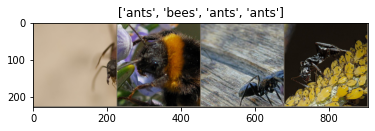

In [9]:
images, labels = next(iter(train_loader))

# 将这个batch中的图像制成表格绘制出来
out = torchvision.utils.make_grid(images)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [14]:
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 5, padding = 2) #输入通道为3，输出通道为4，窗口大小为5，padding为2
        self.pool = nn.MaxPool2d(2, 2) #一个窗口为2*2的pooling运算
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2) #第二层卷积，输入通道为depth[0], 输出通道为depth[1]，窗口为15，padding为2
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1] , 512) #一个线性连接层，输入尺寸为最后一层立方体的平铺，输出层512个节点
        self.fc2 = nn.Linear(512, num_classes) #最后一层线性分类单元，输入为

    def forward(self, x):
        #神经网络完成一步前馈运算的过程，从输入到输出
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # 将立体的Tensor全部转换成一维的Tensor。两次pooling操作，所以图像维度减少了1/4
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        x = F.relu(self.fc1(x)) #全链接，激活函数
        x = F.dropout(x, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        x = self.fc2(x) #全链接，激活函数
        x = F.log_softmax(x, dim=1) #log_softmax可以理解为概率对数值
        return x
    
    def retrieve_features(self, x):
        #提取卷积神经网络的特征图的函数，返回feature_map1, feature_map2为前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool(feature_map1)
        feature_map2 = F.relu(self.conv2(x))
        return (feature_map1, feature_map2)
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行10列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    # rights装到cpu中，以便后面打印出来   --hq20200726
    rights = rights.cpu() if rights.is_cuda else rights
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

In [15]:
net=ConvNet()
net=net.cuda()
criterion = nn.CrossEntropyLoss() #Loss函数的定义
optimizer = optim.SGD(net.parameters(), lr = 0.0001, momentum=0.9)
# 加载网络
net = ConvNet()
# 如果有GPU就把网络加载到GPU中
net = net.cuda() if use_cuda else net
criterion = nn.CrossEntropyLoss() #Loss函数的定义
optimizer = optim.SGD(net.parameters(), lr = 0.0001, momentum=0.9)

record = [] #记录准确率等数值的容器

#开始训练循环
num_epochs = 20
net.train(True) # 给网络模型做标记，标志说模型在训练集上训练
best_model = net
best_r = 0.0
for epoch in range(num_epochs):
    #optimizer = exp_lr_scheduler(optimizer, epoch)
    train_rights = [] #记录训练数据集准确率的容器
    train_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):  #针对容器中的每一个批进行循环
        data, target = data.clone().detach().requires_grad_(True), target.clone().detach()#data为图像，target为标签
        # 如果有GPU就把数据加载到GPU上
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = net(data) #完成一次预测
        loss = criterion(output, target) #计算误差
        optimizer.zero_grad() #清空梯度
        loss.backward() #反向传播
        optimizer.step() #一步随机梯度下降
        right = rightness(output, target) #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
        train_rights.append(right) #将计算结果装到列表容器中
        #因为所有计算都在GPU中，打印的数据再加载到CPU中
        loss = loss.cpu() if use_cuda else loss
        train_losses.append(loss.data.numpy())

    
     #train_r为一个二元组，分别记录训练集中分类正确的数量和该集合中总的样本数
    train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
    #在测试集上分批运行，并计算总的正确率
    net.eval() #标志模型当前为运行阶段
    test_loss = 0
    correct = 0
    vals = []
    #对测试数据集进行循环
    for data, target in val_loader:
        data, target = data.clone().detach().requires_grad_(False), target.clone().detach()
        # 如果GPU可用，就把数据加载到GPU中
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = net(data) #将特征数据喂入网络，得到分类的输出
        val = rightness(output, target) #获得正确样本数以及总样本数
        vals.append(val) #记录结果

    #计算准确率
    val_r = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
    val_ratio = 1.0*val_r[0]/val_r[1]
    
    if val_ratio > best_r:
        best_r = val_ratio
        best_model = copy.deepcopy(net)
    #打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
    print('训练周期: {} \tLoss: {:.6f}\t训练正确率: {:.2f}%, 校验正确率: {:.2f}%'.format(
        epoch, np.mean(train_losses), 100. * train_r[0].numpy() / train_r[1], 100. * val_r[0].numpy()/val_r[1]))       
    record.append([np.mean(train_losses), train_r[0].numpy() / train_r[1], val_r[0].numpy()/val_r[1]])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


训练周期: 0 	Loss: 0.690367	训练正确率: 47.13%, 校验正确率: 55.56%
训练周期: 1 	Loss: 0.673668	训练正确率: 59.84%, 校验正确率: 49.67%
训练周期: 2 	Loss: 0.663682	训练正确率: 57.38%, 校验正确率: 58.17%
训练周期: 3 	Loss: 0.654751	训练正确率: 59.84%, 校验正确率: 60.78%
训练周期: 4 	Loss: 0.647985	训练正确率: 59.43%, 校验正确率: 51.63%
训练周期: 5 	Loss: 0.643588	训练正确率: 60.66%, 校验正确率: 56.86%
训练周期: 6 	Loss: 0.644224	训练正确率: 54.10%, 校验正确率: 54.25%
训练周期: 7 	Loss: 0.644863	训练正确率: 55.33%, 校验正确率: 54.90%
训练周期: 8 	Loss: 0.628817	训练正确率: 57.79%, 校验正确率: 55.56%
训练周期: 9 	Loss: 0.633478	训练正确率: 60.66%, 校验正确率: 57.52%
训练周期: 10 	Loss: 0.638297	训练正确率: 57.38%, 校验正确率: 58.17%
训练周期: 11 	Loss: 0.638003	训练正确率: 60.25%, 校验正确率: 52.94%
训练周期: 12 	Loss: 0.630553	训练正确率: 59.02%, 校验正确率: 55.56%
训练周期: 13 	Loss: 0.630352	训练正确率: 59.43%, 校验正确率: 53.59%
训练周期: 14 	Loss: 0.620201	训练正确率: 60.66%, 校验正确率: 54.25%
训练周期: 15 	Loss: 0.621269	训练正确率: 61.07%, 校验正确率: 53.59%
训练周期: 16 	Loss: 0.623040	训练正确率: 56.97%, 校验正确率: 53.59%
训练周期: 17 	Loss: 0.616599	训练正确率: 61.07%, 校验正确率: 54.25%
训练周期: 18 	Loss: 0.612134	训练正确率: 61.89%

In [16]:
net.eval() #标志模型当前为运行阶段
test_loss = 0
correct = 0
vals = []

#对测试数据集进行循环
for data, target in val_loader:
    data, target = data.clone().detach().requires_grad_(False), target.clone().detach()
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    output = net(data) #将特征数据喂入网络，得到分类的输出
    val = rightness(output, target) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].numpy() / rights[1]
right_rate

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.5294117647058824

Text(0, 0.5, 'Error Rate')

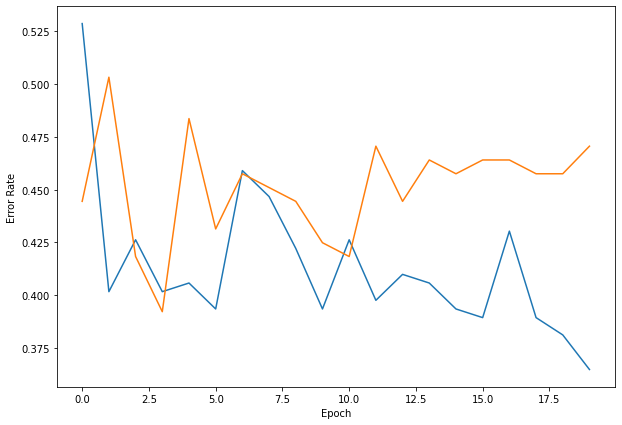

In [17]:
x = [x[0] for x in record]
y = [1 - x[1] for x in record]
z = [1 - x[2] for x in record]
#plt.plot(x)
plt.figure(figsize = (10, 7))
plt.plot(y)
plt.plot(z)
plt.xlabel('Epoch')
plt.ylabel('Error Rate')

In [18]:
net = models.resnet18(pretrained=True)
#如果存在GPU，就将网络加载到GPU上
net = net.cuda() if use_cuda else net
# 将网络的架构打印出来
net

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# 读取最后线性层的输入单元数，这是前面各层卷积提取到的特征数量
num_ftrs = net.fc.in_features

# 重新定义一个全新的线性层，它的输出为2，原本是1000
net.fc = nn.Linear(num_ftrs, 2)

#如果存在GPU则将网络加载到GPU中
net.fc = net.fc.cuda() if use_cuda else net.fc

criterion = nn.CrossEntropyLoss() #Loss函数的定义
# 将网络的所有参数放入优化器中
optimizer = optim.SGD(net.parameters(), lr = 0.0001, momentum=0.9)

record = [] #记录准确率等数值的容器

#开始训练循环
num_epochs = 20
net.train(True) # 给网络模型做标记，标志说模型在训练集上训练
best_model = net
best_r = 0.0
for epoch in range(num_epochs):
    #optimizer = exp_lr_scheduler(optimizer, epoch)
    train_rights = [] #记录训练数据集准确率的容器
    train_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):  #针对容器中的每一个批进行循环
        data, target = data.clone().detach().requires_grad_(True), target.clone().detach() #data为图像，target为标签
        #如果存在GPU则将变量加载到GPU中
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = net(data) #完成一次预测
        loss = criterion(output, target) #计算误差
        optimizer.zero_grad() #清空梯度
        loss.backward() #反向传播
        optimizer.step() #一步随机梯度下降
        right = rightness(output, target) #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
        train_rights.append(right) #将计算结果装到列表容器中
        loss = loss.cpu() if use_cuda else loss
        train_losses.append(loss.data.numpy())

    
        #if batch_idx % 20 == 0: #每间隔100个batch执行一次
     #train_r为一个二元组，分别记录训练集中分类正确的数量和该集合中总的样本数
    train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))

    #在测试集上分批运行，并计算总的正确率
    net.eval() #标志模型当前为运行阶段
    test_loss = 0
    correct = 0
    vals = []
    #对测试数据集进行循环
    for data, target in val_loader:
        #如果存在GPU则将变量加载到GPU中
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = data.clone().detach().requires_grad_(False), target.clone().detach()
        output = net(data) #将特征数据喂入网络，得到分类的输出
        val = rightness(output, target) #获得正确样本数以及总样本数
        vals.append(val) #记录结果

    #计算准确率
    val_r = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
    val_ratio = 1.0*val_r[0].numpy()/val_r[1]
    
    if val_ratio > best_r:
        best_r = val_ratio
        best_model = copy.deepcopy(net)
    #打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
    print('训练周期: {} \tLoss: {:.6f}\t训练正确率: {:.2f}%, 校验正确率: {:.2f}%'.format(
        epoch, np.mean(train_losses), 100. * train_r[0].numpy() / train_r[1], 100. * val_r[0].numpy()/val_r[1]))       
    record.append([np.mean(train_losses), train_r[0].numpy() / train_r[1], val_r[0].numpy()/val_r[1]])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


训练周期: 0 	Loss: 0.644685	训练正确率: 62.30%, 校验正确率: 75.16%
训练周期: 1 	Loss: 0.397306	训练正确率: 84.43%, 校验正确率: 89.54%
训练周期: 2 	Loss: 0.275208	训练正确率: 89.34%, 校验正确率: 93.46%
训练周期: 3 	Loss: 0.172362	训练正确率: 93.85%, 校验正确率: 92.16%
训练周期: 4 	Loss: 0.159985	训练正确率: 94.67%, 校验正确率: 94.12%
训练周期: 5 	Loss: 0.155397	训练正确率: 94.67%, 校验正确率: 83.01%
训练周期: 6 	Loss: 0.209841	训练正确率: 90.16%, 校验正确率: 94.12%
训练周期: 7 	Loss: 0.100666	训练正确率: 95.90%, 校验正确率: 93.46%
训练周期: 8 	Loss: 0.111632	训练正确率: 96.31%, 校验正确率: 94.77%
训练周期: 9 	Loss: 0.264968	训练正确率: 89.34%, 校验正确率: 94.77%
训练周期: 10 	Loss: 0.113629	训练正确率: 95.49%, 校验正确率: 93.46%
训练周期: 11 	Loss: 0.084758	训练正确率: 97.54%, 校验正确率: 92.81%
训练周期: 12 	Loss: 0.059981	训练正确率: 97.95%, 校验正确率: 93.46%
训练周期: 13 	Loss: 0.057215	训练正确率: 97.54%, 校验正确率: 90.85%
训练周期: 14 	Loss: 0.107660	训练正确率: 94.26%, 校验正确率: 95.42%
训练周期: 15 	Loss: 0.067519	训练正确率: 97.13%, 校验正确率: 90.85%
训练周期: 16 	Loss: 0.072647	训练正确率: 97.95%, 校验正确率: 94.12%
训练周期: 17 	Loss: 0.121146	训练正确率: 93.85%, 校验正确率: 92.81%
训练周期: 18 	Loss: 0.059481	训练正确率: 98.36%